In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score, f1_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, StackingClassifier,\
GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

In [18]:
df = pd.read_csv(r'../datasets/reddit_dataframe.csv')
df = df[['subreddit', 'selftext']]

In [19]:
df[['subreddit','selftext']].isna().sum()

subreddit    0
selftext     1
dtype: int64

In [20]:
null_index = list(df[df[['selftext', 'subreddit']].isnull().any(axis = 1)].index)
df.drop(index = null_index, inplace = True)
df.index = range(len(df))

In [21]:
df[['subreddit','selftext']].isna().sum()

subreddit    0
selftext     0
dtype: int64

In [30]:
df['subreddit'].value_counts(normalize = True)

jobs        0.529609
antiwork    0.470391
Name: subreddit, dtype: float64

The baseline score is .53. I will stratify even though the classes are fairly balanced.

In [22]:
X = df['selftext']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

***Logistic Regression***

In [36]:
tvec_log_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression())
])


pipe_tvec_params = {
    'tvec__max_features': [2750, 3000],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'tvec__stop_words': ['english', None],
}


gs_log_tvec = GridSearchCV(tvec_log_pipe, 
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_log_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('log', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [2750, 3000],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english', None]})

**ITERATION 1**

In [37]:
print(f"Training accuracy: {gs_log_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_log_tvec.score(X_test, y_test).round(5)}")

preds = gs_log_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")
print("==============================================================================================================")
print(f"PARAMETERS:{pipe_tvec_params}")
print(f"Best params: {gs_log_tvec.best_params_}")

Training accuracy: 0.86632
Test accuracy: 0.80745
Balanced accuracy: 0.80633
F1 score: 0.80745
PARAMETERS:{'tvec__max_features': [2750, 3000], 'tvec__ngram_range': [(1, 2), (1, 3)], 'tvec__stop_words': ['english', None]}
Best params: {'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


The F1 is high, so it seems to be balancing precision and recall well, i.e. it's doing a good job of minimizing both false negatives and incorrect guesses of the positive class (in this case, r/Jobs, which is the larger class).

I'll try tuning a bit further with the params I already have, then I'll try tuning for C

**ITERATION 2**

In [49]:
tvec_log_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression())
])


pipe_tvec_params = {
    'tvec__max_features': [2600, 2800, 3000],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__stop_words': ['english'],
}


gs_log_tvec = GridSearchCV(tvec_log_pipe, 
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_log_tvec.fit(X_train, y_train)

print(f"Training accuracy: {gs_log_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_log_tvec.score(X_test, y_test).round(5)}")

preds = gs_log_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")
print("==============================================================================================================")
print(f"PARAMETERS:{pipe_tvec_params}")
print(f"Best params: {gs_log_tvec.best_params_}")

Training accuracy: 0.86399
Test accuracy: 0.80105
Balanced accuracy: 0.79988
F1 score: 0.80105
PARAMETERS:{'tvec__max_features': [2600, 2800, 3000], 'tvec__ngram_range': [(1, 1), (1, 2)], 'tvec__stop_words': ['english']}
Best params: {'tvec__max_features': 2600, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


This isn't improving, so I'll stick with the original params and try different values for C

**ITERATION 3: Gridsearching C**

In [57]:
tvec_log_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression())
])


pipe_tvec_params = {
    'tvec__max_features': [3000, 3100, 3300],
    'tvec__ngram_range': [(1, 2)],
    'tvec__stop_words': ['english'],
    'log__C': [1, 2, 3]
}


gs_log_tvec = GridSearchCV(tvec_log_pipe, 
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_log_tvec.fit(X_train, y_train)

print(f"Training accuracy: {gs_log_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_log_tvec.score(X_test, y_test).round(5)}")

preds = gs_log_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")
print("==============================================================================================================")
print(f"PARAMETERS:{pipe_tvec_params}")
print(f"Best params: {gs_log_tvec.best_params_}")

Training accuracy: 0.89523
Test accuracy: 0.8121
Balanced accuracy: 0.81052
F1 score: 0.8121
PARAMETERS:{'tvec__max_features': [3000, 3100, 3300], 'tvec__ngram_range': [(1, 2)], 'tvec__stop_words': ['english'], 'log__C': [1, 2, 3]}
Best params: {'log__C': 2, 'tvec__max_features': 3100, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


The model is now more overfit, but the test performance is improved so I think it's a worthwhile tradeoff.

Making a ROC Curve of Iteration 3:

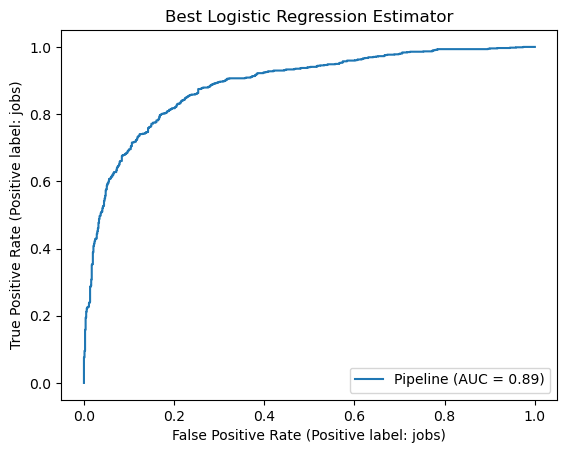

In [118]:
best_log = gs_log_tvec.best_estimator_ 
RocCurveDisplay.from_estimator(best_log, X_test, y_test);
plt.title("Best Logistic Regression Estimator");
plt.savefig('logreg_roc.png')

***kNN***

There's only one feature in this dataset, so kNN could potentially do a lot better than some of the other approaches. It does well in circumstances with low feature dimensionality.

For that reason, I'm a bit skeptical that this type will perform as well as LogReg.

In [91]:
tvec_knn_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])


pipe_tvec_params = {
    'tvec__max_features': [2000, 3000],
    'tvec__ngram_range': [(1,2), (1,3)],
    'knn__n_neighbors': [3, 5, 7],
}


gs_knn_tvec = GridSearchCV(tvec_knn_pipe,
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_knn_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'tvec__max_features': [2000, 3000],
                         'tvec__ngram_range': [(1, 2), (1, 3)]})

**ITERATION 1**

In [92]:
print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {gs_knn_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_knn_tvec.score(X_test, y_test).round(5)}")

preds = gs_knn_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

print(f"Best params: {gs_knn_tvec.best_params_}")

PARAMETERS:{'tvec__max_features': [2000, 3000], 'tvec__ngram_range': [(1, 2), (1, 3)], 'knn__n_neighbors': [3, 5, 7]}
Training accuracy: 0.59449
Test accuracy: 0.62071
Balanced accuracy: 0.59793
F1 score: 0.62071
Best params: {'knn__n_neighbors': 7, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2)}


**ITERATION 2**

In [97]:
tvec_knn_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])


pipe_tvec_params = {
    'tvec__max_features': [1500, 2000,],
    'tvec__ngram_range': [(1, 1), (1,2)],
    'knn__n_neighbors': [7, 9, 11],
}


gs_knn_tvec = GridSearchCV(tvec_knn_pipe,
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_knn_tvec.fit(X_train, y_train)

print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {gs_knn_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_knn_tvec.score(X_test, y_test).round(5)}")

preds = gs_knn_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

print(f"Best params: {gs_knn_tvec.best_params_}")

PARAMETERS:{'tvec__max_features': [1500, 2000], 'tvec__ngram_range': [(1, 1), (1, 2)], 'knn__n_neighbors': [7, 9, 11]}
Training accuracy: 0.59488
Test accuracy: 0.60151
Balanced accuracy: 0.57904
F1 score: 0.60151
Best params: {'knn__n_neighbors': 11, 'tvec__max_features': 1500, 'tvec__ngram_range': (1, 1)}


Setting the n_neighbors to 11 didn't seem to have much of an effect on the scores. The gridsearch is choosing the highest n_neighbors available, but it's not actually improving the outcome. The test score from the previous iteration was actually higher. I'll stick with iteration 1.

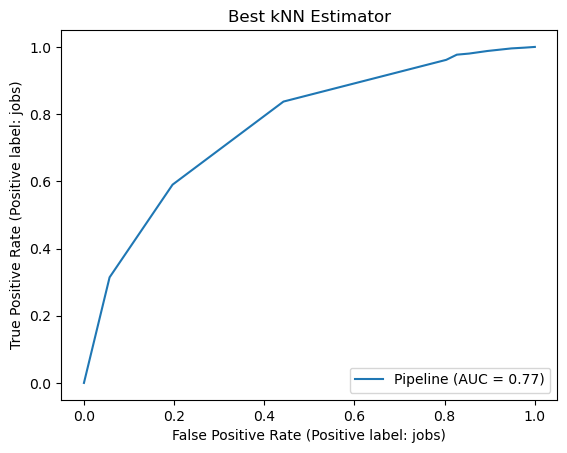

In [119]:
best_knn = gs_knn_tvec.best_estimator_ 
RocCurveDisplay.from_estimator(best_knn, X_test, y_test);
plt.title("Best kNN Estimator");
plt.savefig('knn_roc.png')

***Bernoulli Naive Bayes***

Since this is a binary classification task, I'll use a Bernoulli naive bayes.

In [ ]:
tvec_NB_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('NB', BernoulliNB())
])


pipe_tvec_params = {
    'tvec__max_features': [1000, 3000],
    'tvec__ngram_range': [(1,2), (1,3)],
    'NB__alpha': [.25, 1],
}


gs_NB_tvec = GridSearchCV(tvec_NB_pipe,
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_NB_tvec.fit(X_train, y_train)

**ITERATION 1**

In [63]:
print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {gs_NB_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_NB_tvec.score(X_test, y_test).round(5)}")

preds = gs_NB_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

print(f"Best params: {gs_NB_tvec.best_params_}")

PARAMETERS:{'tvec__max_features': [1000, 3000], 'tvec__ngram_range': [(1, 2), (1, 3)], 'NB__alpha': [0.25, 1]}
Training accuracy: 0.6849
Test accuracy: 0.68819
Balanced accuracy: 0.68258
F1 score: 0.68819
Best params: {'NB__alpha': 0.25, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 3)}


**ITERATION 2: Trying a smaller NB_alpha, larger ngram range, larger tvec_max_features**

In [72]:
tvec_NB_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('NB', BernoulliNB())
])


pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__ngram_range': [(1,2), (1,3), (1,4)],
    'NB__alpha': [.1, .25, .5],
}


gs_NB_tvec = GridSearchCV(tvec_NB_pipe,
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_NB_tvec.fit(X_train, y_train)

print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {gs_NB_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_NB_tvec.score(X_test, y_test).round(5)}")

preds = gs_NB_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

print(f"Best params: {gs_NB_tvec.best_params_}")

PARAMETERS:{'tvec__max_features': [2000, 3000, 4000], 'tvec__ngram_range': [(1, 2), (1, 3), (1, 4)], 'NB__alpha': [0.1, 0.25, 0.5]}
Training accuracy: 0.69519
Test accuracy: 0.69343
Balanced accuracy: 0.68767
F1 score: 0.69343
Best params: {'NB__alpha': 0.25, 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 3)}


**ITERATION 3**

In [82]:
tvec_NB_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('NB', BernoulliNB())
])


pipe_tvec_params = {
    'tvec__max_features': [4000],
    'tvec__ngram_range': [(1,3)],
    'NB__alpha': [.1, .25, .5],
}


gs_NB_tvec = GridSearchCV(tvec_NB_pipe,
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_NB_tvec.fit(X_train, y_train)

print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {gs_NB_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_NB_tvec.score(X_test, y_test).round(5)}")

preds = gs_NB_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

print(f"Best params: {gs_NB_tvec.best_params_}")

PARAMETERS:{'tvec__max_features': [4000], 'tvec__ngram_range': [(1, 3)], 'NB__alpha': [0.1, 0.25, 0.5]}
Training accuracy: 0.69519
Test accuracy: 0.69343
Balanced accuracy: 0.68767
F1 score: 0.69343
Best params: {'NB__alpha': 0.25, 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 3)}


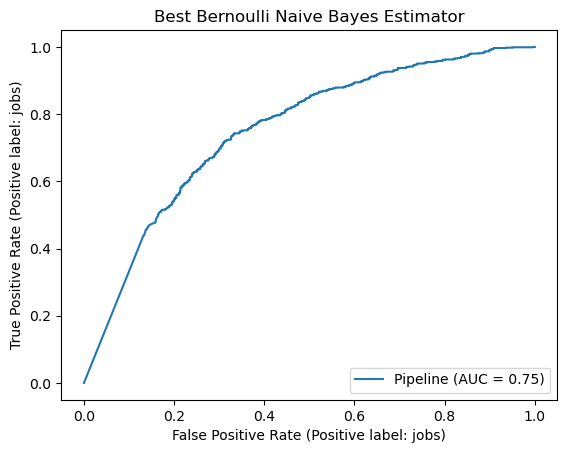

In [120]:
best_nb = gs_NB_tvec.best_estimator_ 
RocCurveDisplay.from_estimator(best_nb, X_test, y_test);
plt.title("Best Bernoulli Naive Bayes Estimator");
plt.savefig('nb_roc.png')

Although this estimator is not performing especially well, it's very balanced in terms of train/test accuracy.

***Random Forest***

    Best params: {'rf__max_depth': 10, 'tvec__max_df': 0.7, 'tvec__max_features': 1000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

In [67]:
tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])


pipe_tvec_params = {
    'tvec__max_features': [700, 1000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.3, .5],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__max_depth': [10],
    'rf__min_samples_split': [2,3]
}


gs_rf_tvec = GridSearchCV(tvec_rf_pipe,
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_rf_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10], 'rf__min_samples_split': [2, 3],
                         'tvec__max_df': [0.3, 0.5],
                         'tvec__max_features': [700, 1000],
                         'tvec__min_df': [1, 2],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']})

**ITERATION 1**

In [68]:
print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {gs_rf_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_rf_tvec.score(X_test, y_test).round(5)}")

preds = gs_rf_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

print(f"Best params: {gs_rf_tvec.best_params_}")

PARAMETERS:{'tvec__max_features': [700, 1000], 'tvec__min_df': [1, 2], 'tvec__max_df': [0.3, 0.5], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 1), (1, 2)], 'rf__max_depth': [10], 'rf__min_samples_split': [2, 3]}
Training accuracy: 0.857
Test accuracy: 0.78301
Balanced accuracy: 0.77832
F1 score: 0.78301
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'tvec__max_df': 0.5, 'tvec__max_features': 700, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


**ITERATION 2: Smaller tvec_max_features, larger tvec_max_df**

In [78]:
tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])


pipe_tvec_params = {
    'tvec__max_features': [650, 700, 750],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.7, .9],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__max_depth': [10],
    'rf__min_samples_split': [2, 3]
}


gs_rf_tvec = GridSearchCV(tvec_rf_pipe,
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_rf_tvec.fit(X_train, y_train)

print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {gs_rf_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_rf_tvec.score(X_test, y_test).round(5)}")

preds = gs_rf_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

print(f"Best params: {gs_rf_tvec.best_params_}")

PARAMETERS:{'tvec__max_features': [650, 700, 750], 'tvec__min_df': [1, 2], 'tvec__max_df': [0.7, 0.9], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 1), (1, 2)], 'rf__max_depth': [10], 'rf__min_samples_split': [2, 3]}
Training accuracy: 0.86632
Test accuracy: 0.78767
Balanced accuracy: 0.78347
F1 score: 0.78767
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 3, 'tvec__max_df': 0.9, 'tvec__max_features': 700, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


**ITERATION 3**

In [75]:
tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])


pipe_tvec_params = {
    'tvec__max_features': [1000],
    'tvec__min_df': [3],
    'tvec__max_df': [.8],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1)],
    'rf__max_depth': [10, 11, 12],
    'rf__min_samples_split': [3]
}


gs_rf_tvec = GridSearchCV(tvec_rf_pipe,
                  param_grid = pipe_tvec_params, 
                  cv = 5, n_jobs = -1) 

gs_rf_tvec.fit(X_train, y_train)

print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {gs_rf_tvec.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {gs_rf_tvec.score(X_test, y_test).round(5)}")

preds = gs_rf_tvec.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

print(f"Best params: {gs_rf_tvec.best_params_}")

PARAMETERS:{'tvec__max_features': [900, 1000, 1100], 'tvec__min_df': [2, 3, 4], 'tvec__max_df': [0.6, 0.7, 0.8], 'tvec__stop_words': ['english'], 'tvec__ngram_range': [(1, 1), (1, 2)], 'rf__max_depth': [10], 'rf__min_samples_split': [2, 3, 4]}
Training accuracy: 0.8638
Test accuracy: 0.78069
Balanced accuracy: 0.77605
F1 score: 0.78069
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 3, 'tvec__max_df': 0.8, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


    Best params: {'rf__max_depth': 10, 'tvec__max_df': 0.7, 'tvec__max_features': 1000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

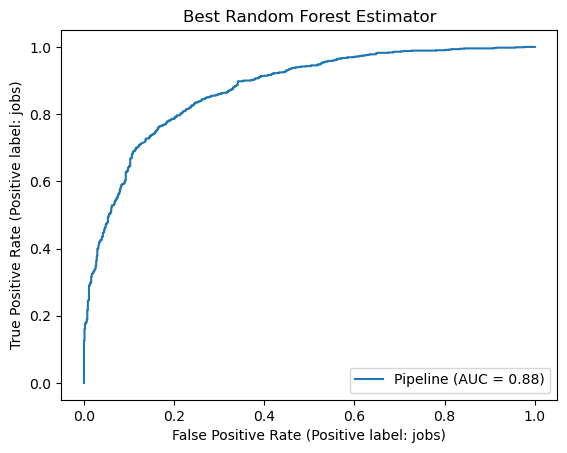

In [121]:
best_rf = gs_rf_tvec.best_estimator_ 
RocCurveDisplay.from_estimator(best_rf, X_test, y_test);
plt.title("Best Random Forest Estimator");
plt.savefig('rf_roc.png')

***Stacked Model***

In [105]:
tvec_log_pipe = Pipeline([
    ('tvec', TfidfVectorizer(max_features = 3000, ngram_range = (1, 3))),
    ('log', LogisticRegression())
])

tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer(max_features = 3000, ngram_range = (1, 2))),
    ('rf', RandomForestClassifier())
])

estimators = [
    ('tvec_log', tvec_log_pipe),
    ('tvec_rf', tvec_rf_pipe)
]

clf = StackingClassifier(estimators = estimators,
                         final_estimator = GradientBoostingClassifier())
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('tvec_log',
                                Pipeline(steps=[('tvec',
                                                 TfidfVectorizer(max_features=3000,
                                                                 ngram_range=(1,
                                                                              3))),
                                                ('log',
                                                 LogisticRegression())])),
                               ('tvec_rf',
                                Pipeline(steps=[('tvec',
                                                 TfidfVectorizer(max_features=3000,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('rf',
                                                 RandomForestClassifier())]))],
                   final_estimator=GradientBoostingClassifier())

**ITERATION 1**

In [106]:
print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {clf.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {clf.score(X_test, y_test).round(5)}")

preds = clf.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

PARAMETERS:{'tvec__max_features': [1500, 2000], 'tvec__ngram_range': [(1, 1), (1, 2)], 'knn__n_neighbors': [7, 9, 11]}
Training accuracy: 0.99806
Test accuracy: 0.83944
Balanced accuracy: 0.83751
F1 score: 0.83944


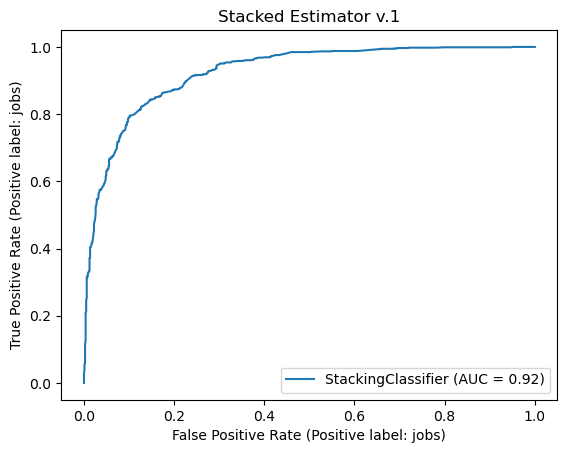

In [122]:
RocCurveDisplay.from_estimator(clf, X_test, y_test);
plt.title("Stacked Estimator v.1");
plt.savefig('stacked_roc.png')

**ITERATION 2: I'll now add in the best Logistic Regression and Random Forest params and see what happens**

Logistic Regression

    Best params: {'log__C': 2, 'tvec__max_features': 3100, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}

Random Forest

    Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 3, 'tvec__max_df': 0.9, 'tvec__max_features': 700, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}

In [114]:
tvec_log_pipe = Pipeline([
    ('tvec', TfidfVectorizer(max_features = 3100, ngram_range = (1, 2), stop_words = 'english')),
    ('log', LogisticRegression(C = 2))
])

tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer(max_features = 700, ngram_range = (1, 2), max_df = .9, min_df = 2,
                             stop_words = 'english')),
    ('rf', RandomForestClassifier(max_depth = 10, min_samples_split = 3))
])

estimators = [
    ('tvec_log', tvec_log_pipe),
    ('tvec_rf', tvec_rf_pipe)
]

clf2 = StackingClassifier(estimators = estimators,
                         final_estimator = GradientBoostingClassifier())
clf2.fit(X_train, y_train)

print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {clf2.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {clf2.score(X_test, y_test).round(5)}")

preds = clf2.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

PARAMETERS:{'tvec__max_features': [1500, 2000], 'tvec__ngram_range': [(1, 1), (1, 2)], 'knn__n_neighbors': [7, 9, 11]}
Training accuracy: 0.8962
Test accuracy: 0.81326
Balanced accuracy: 0.81354
F1 score: 0.81326


Although this iteration is not as overfit as iteration 1, the test score is lower, so I would say it's performing worse. That said, iteration 2's F1 score is better. Precision vs recall is not especially important to me in this case, so I won't make a confusion matrix. All I am interested in is classifying which subreddit posts are from.

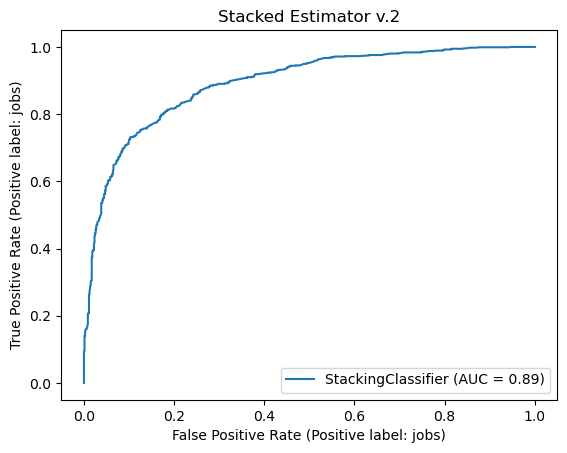

In [115]:
RocCurveDisplay.from_estimator(clf2, X_test, y_test);
plt.title("Stacked Estimator v.2");

**ITERATION 3: Defaults**

Just out of curiosity, I'll try the defaults, except for stop_words, which I think has shown itself to be useful.

In [116]:
tvec_log_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = 'english')),
    ('log', LogisticRegression())
])

tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = 'english')),
    ('rf', RandomForestClassifier())
])

estimators = [
    ('tvec_log', tvec_log_pipe),
    ('tvec_rf', tvec_rf_pipe)
]

clf3 = StackingClassifier(estimators = estimators,
                         final_estimator = GradientBoostingClassifier())
clf3.fit(X_train, y_train)

print(f"PARAMETERS:{pipe_tvec_params}")
print("===============================================================================================")
print(f"Training accuracy: {clf3.score(X_train, y_train).round(5)}")
print(f"Test accuracy: {clf3.score(X_test, y_test).round(5)}")

preds = clf3.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, preds).round(5)}")
print(f"F1 score: {f1_score(y_test, preds, average = 'micro').round(5)}")

PARAMETERS:{'tvec__max_features': [1500, 2000], 'tvec__ngram_range': [(1, 1), (1, 2)], 'knn__n_neighbors': [7, 9, 11]}
Training accuracy: 0.98972
Test accuracy: 0.84759
Balanced accuracy: 0.84555
F1 score: 0.84759


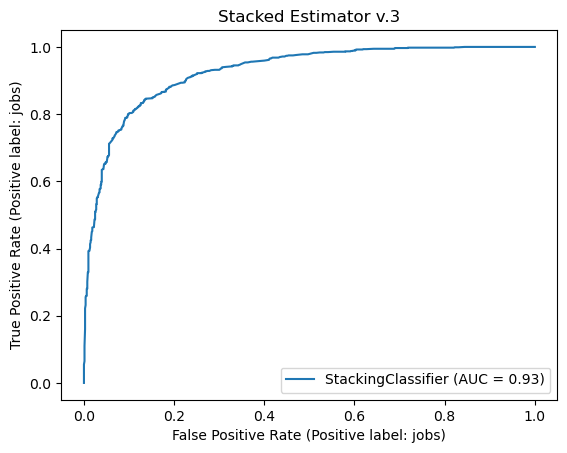

In [123]:
RocCurveDisplay.from_estimator(clf3, X_test, y_test);
plt.title("Stacked Estimator v.3");
plt.savefig('stacked_v3.png')

This is my best model so far, from the perspective of test score. It's very overfit, but considering the test performance, I'd say this is the winner. Based on F1, it does not appear to be biased towards accurately guessing one class or the other, but since I stratified and the classes were balanced from the start, that was never a major concern.